<a href="https://colab.research.google.com/github/eveapp/data_science/blob/Ketki/Topic%20Classification%20F20/EAFC_Text__Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords, wordnet
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Read labelled data csv 

In [ ]:
corpus = pd.read_csv("EAFC_Raw.csv",encoding='latin-1')
corpus.head()

,Unnamed: 0,title,body,label,clean_body,clean_body_str
0,0,Fuck that Bell!,"Sorry for the title, but I wish the bell ringi...",6.0,"['fuck', 'bell', 'sorry', 'title', 'wish', 'be...",fuck bell sorry title wish bell ringing party ...
1,1,Father suffering from end stage aggression. Wo...,My dad was diagnosed with stage 4 bone cancer ...,7.0,"['famrel', 'suffering', 'end', 'stage', 'aggre...",famrel suffering end stage aggression will not...
2,2,last chemo was today :),just finished my last of 12 abvd infusions. I ...,2.0,"['last', 'chemo', 'today', 'just', 'finished',...",last chemo today just finished last number abv...
3,3,ER phobia?,Have any of your loved ones checked out of the...,7.0,"['er', 'phobia', 'any', 'loved', 'numbers', 'c...",er phobia any loved numbers checked out hospit...
4,4,"8 minutes into his appointment, another scene ...",At this point itâs just funny to me. Iâm n...,3.0,"['number', 'minutes', 'appointment', 'another'...",number minutes appointment another scene made ...


In [ ]:
#np.random.seed(500)

In [ ]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      704 non-null    int64  
 1   title           704 non-null    object 
 2   body            704 non-null    object 
 3   label           704 non-null    float64
 4   clean_body      704 non-null    object 
 5   clean_body_str  704 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 33.1+ KB


In [ ]:
#Tokenize
corpus['tokenized'] = corpus['clean_body_str'].apply(word_tokenize)
corpus.head()

,Unnamed: 0,title,body,label,clean_body,clean_body_str,tokenized
0,0,Fuck that Bell!,"Sorry for the title, but I wish the bell ringi...",6.0,"['fuck', 'bell', 'sorry', 'title', 'wish', 'be...",fuck bell sorry title wish bell ringing party ...,"[fuck, bell, sorry, title, wish, bell, ringing..."
1,1,Father suffering from end stage aggression. Wo...,My dad was diagnosed with stage 4 bone cancer ...,7.0,"['famrel', 'suffering', 'end', 'stage', 'aggre...",famrel suffering end stage aggression will not...,"[famrel, suffering, end, stage, aggression, wi..."
2,2,last chemo was today :),just finished my last of 12 abvd infusions. I ...,2.0,"['last', 'chemo', 'today', 'just', 'finished',...",last chemo today just finished last number abv...,"[last, chemo, today, just, finished, last, num..."
3,3,ER phobia?,Have any of your loved ones checked out of the...,7.0,"['er', 'phobia', 'any', 'loved', 'numbers', 'c...",er phobia any loved numbers checked out hospit...,"[er, phobia, any, loved, numbers, checked, out..."
4,4,"8 minutes into his appointment, another scene ...",At this point itâs just funny to me. Iâm n...,3.0,"['number', 'minutes', 'appointment', 'another'...",number minutes appointment another scene made ...,"[number, minutes, appointment, another, scene,..."


In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
#Tagging Parts of Speech in the tokenized 
corpus['pos_tags'] = corpus['tokenized'].apply(nltk.tag.pos_tag)
corpus.head()

,Unnamed: 0,title,body,label,clean_body,clean_body_str,tokenized,pos_tags
0,0,Fuck that Bell!,"Sorry for the title, but I wish the bell ringi...",6.0,"['fuck', 'bell', 'sorry', 'title', 'wish', 'be...",fuck bell sorry title wish bell ringing party ...,"[fuck, bell, sorry, title, wish, bell, ringing...","[(fuck, NN), (bell, NN), (sorry, JJ), (title, ..."
1,1,Father suffering from end stage aggression. Wo...,My dad was diagnosed with stage 4 bone cancer ...,7.0,"['famrel', 'suffering', 'end', 'stage', 'aggre...",famrel suffering end stage aggression will not...,"[famrel, suffering, end, stage, aggression, wi...","[(famrel, NN), (suffering, VBG), (end, NN), (s..."
2,2,last chemo was today :),just finished my last of 12 abvd infusions. I ...,2.0,"['last', 'chemo', 'today', 'just', 'finished',...",last chemo today just finished last number abv...,"[last, chemo, today, just, finished, last, num...","[(last, JJ), (chemo, NN), (today, NN), (just, ..."
3,3,ER phobia?,Have any of your loved ones checked out of the...,7.0,"['er', 'phobia', 'any', 'loved', 'numbers', 'c...",er phobia any loved numbers checked out hospit...,"[er, phobia, any, loved, numbers, checked, out...","[(er, RB), (phobia, VBZ), (any, DT), (loved, J..."
4,4,"8 minutes into his appointment, another scene ...",At this point itâs just funny to me. Iâm n...,3.0,"['number', 'minutes', 'appointment', 'another'...",number minutes appointment another scene made ...,"[number, minutes, appointment, another, scene,...","[(number, NN), (minutes, NNS), (appointment, V..."


In [ ]:
corpus['wordnet_pos'] = corpus['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
corpus.head()

,Unnamed: 0,title,body,label,clean_body,clean_body_str,tokenized,pos_tags,wordnet_pos
0,0,Fuck that Bell!,"Sorry for the title, but I wish the bell ringi...",6.0,"['fuck', 'bell', 'sorry', 'title', 'wish', 'be...",fuck bell sorry title wish bell ringing party ...,"[fuck, bell, sorry, title, wish, bell, ringing...","[(fuck, NN), (bell, NN), (sorry, JJ), (title, ...","[(fuck, n), (bell, n), (sorry, a), (title, n),..."
1,1,Father suffering from end stage aggression. Wo...,My dad was diagnosed with stage 4 bone cancer ...,7.0,"['famrel', 'suffering', 'end', 'stage', 'aggre...",famrel suffering end stage aggression will not...,"[famrel, suffering, end, stage, aggression, wi...","[(famrel, NN), (suffering, VBG), (end, NN), (s...","[(famrel, n), (suffering, v), (end, n), (stage..."
2,2,last chemo was today :),just finished my last of 12 abvd infusions. I ...,2.0,"['last', 'chemo', 'today', 'just', 'finished',...",last chemo today just finished last number abv...,"[last, chemo, today, just, finished, last, num...","[(last, JJ), (chemo, NN), (today, NN), (just, ...","[(last, a), (chemo, n), (today, n), (just, r),..."
3,3,ER phobia?,Have any of your loved ones checked out of the...,7.0,"['er', 'phobia', 'any', 'loved', 'numbers', 'c...",er phobia any loved numbers checked out hospit...,"[er, phobia, any, loved, numbers, checked, out...","[(er, RB), (phobia, VBZ), (any, DT), (loved, J...","[(er, r), (phobia, v), (any, n), (loved, a), (..."
4,4,"8 minutes into his appointment, another scene ...",At this point itâs just funny to me. Iâm n...,3.0,"['number', 'minutes', 'appointment', 'another'...",number minutes appointment another scene made ...,"[number, minutes, appointment, another, scene,...","[(number, NN), (minutes, NNS), (appointment, V...","[(number, n), (minutes, n), (appointment, v), ..."


In [ ]:
#Lemmatization
wnl = WordNetLemmatizer()
corpus['lemmatized'] = corpus['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
corpus.head()

,Unnamed: 0,title,body,label,clean_body,clean_body_str,tokenized,pos_tags,wordnet_pos,lemmatized
0,0,Fuck that Bell!,"Sorry for the title, but I wish the bell ringi...",6.0,"['fuck', 'bell', 'sorry', 'title', 'wish', 'be...",fuck bell sorry title wish bell ringing party ...,"[fuck, bell, sorry, title, wish, bell, ringing...","[(fuck, NN), (bell, NN), (sorry, JJ), (title, ...","[(fuck, n), (bell, n), (sorry, a), (title, n),...","[fuck, bell, sorry, title, wish, bell, ring, p..."
1,1,Father suffering from end stage aggression. Wo...,My dad was diagnosed with stage 4 bone cancer ...,7.0,"['famrel', 'suffering', 'end', 'stage', 'aggre...",famrel suffering end stage aggression will not...,"[famrel, suffering, end, stage, aggression, wi...","[(famrel, NN), (suffering, VBG), (end, NN), (s...","[(famrel, n), (suffering, v), (end, n), (stage...","[famrel, suffer, end, stage, aggression, will,..."
2,2,last chemo was today :),just finished my last of 12 abvd infusions. I ...,2.0,"['last', 'chemo', 'today', 'just', 'finished',...",last chemo today just finished last number abv...,"[last, chemo, today, just, finished, last, num...","[(last, JJ), (chemo, NN), (today, NN), (just, ...","[(last, a), (chemo, n), (today, n), (just, r),...","[last, chemo, today, just, finish, last, numbe..."
3,3,ER phobia?,Have any of your loved ones checked out of the...,7.0,"['er', 'phobia', 'any', 'loved', 'numbers', 'c...",er phobia any loved numbers checked out hospit...,"[er, phobia, any, loved, numbers, checked, out...","[(er, RB), (phobia, VBZ), (any, DT), (loved, J...","[(er, r), (phobia, v), (any, n), (loved, a), (...","[er, phobia, any, loved, number, check, out, h..."
4,4,"8 minutes into his appointment, another scene ...",At this point itâs just funny to me. Iâm n...,3.0,"['number', 'minutes', 'appointment', 'another'...",number minutes appointment another scene made ...,"[number, minutes, appointment, another, scene,...","[(number, NN), (minutes, NNS), (appointment, V...","[(number, n), (minutes, n), (appointment, v), ...","[number, minute, appointment, another, scene, ..."


In [ ]:
#Add Lemma Str column
corpus['lemma_str'] = [' '.join(map(str,l)) for l in corpus['lemmatized']]
corpus.head()

,Unnamed: 0,title,body,label,clean_body,clean_body_str,tokenized,pos_tags,wordnet_pos,lemmatized,lemma_str
0,0,Fuck that Bell!,"Sorry for the title, but I wish the bell ringi...",6.0,"['fuck', 'bell', 'sorry', 'title', 'wish', 'be...",fuck bell sorry title wish bell ringing party ...,"[fuck, bell, sorry, title, wish, bell, ringing...","[(fuck, NN), (bell, NN), (sorry, JJ), (title, ...","[(fuck, n), (bell, n), (sorry, a), (title, n),...","[fuck, bell, sorry, title, wish, bell, ring, p...",fuck bell sorry title wish bell ring party mus...
1,1,Father suffering from end stage aggression. Wo...,My dad was diagnosed with stage 4 bone cancer ...,7.0,"['famrel', 'suffering', 'end', 'stage', 'aggre...",famrel suffering end stage aggression will not...,"[famrel, suffering, end, stage, aggression, wi...","[(famrel, NN), (suffering, VBG), (end, NN), (s...","[(famrel, n), (suffering, v), (end, n), (stage...","[famrel, suffer, end, stage, aggression, will,...",famrel suffer end stage aggression will not ta...
2,2,last chemo was today :),just finished my last of 12 abvd infusions. I ...,2.0,"['last', 'chemo', 'today', 'just', 'finished',...",last chemo today just finished last number abv...,"[last, chemo, today, just, finished, last, num...","[(last, JJ), (chemo, NN), (today, NN), (just, ...","[(last, a), (chemo, n), (today, n), (just, r),...","[last, chemo, today, just, finish, last, numbe...",last chemo today just finish last number abvd ...
3,3,ER phobia?,Have any of your loved ones checked out of the...,7.0,"['er', 'phobia', 'any', 'loved', 'numbers', 'c...",er phobia any loved numbers checked out hospit...,"[er, phobia, any, loved, numbers, checked, out...","[(er, RB), (phobia, VBZ), (any, DT), (loved, J...","[(er, r), (phobia, v), (any, n), (loved, a), (...","[er, phobia, any, loved, number, check, out, h...",er phobia any loved number check out hospital ...
4,4,"8 minutes into his appointment, another scene ...",At this point itâs just funny to me. Iâm n...,3.0,"['number', 'minutes', 'appointment', 'another'...",number minutes appointment another scene made ...,"[number, minutes, appointment, another, scene,...","[(number, NN), (minutes, NNS), (appointment, V...","[(number, n), (minutes, n), (appointment, v), ...","[number, minute, appointment, another, scene, ...",number minute appointment another scene make p...


In [ ]:
#Merge

In [ ]:
labels = [9,8,0,7,2,3,4,5,6,1]
df = corpus.query('label in @labels')
df['label'] = df['label'].replace([2,3,4,5,6,1], 1)
df.head()


,Unnamed: 0,title,body,label,clean_body,clean_body_str,tokenized,pos_tags,wordnet_pos,lemmatized,lemma_str
0,0,Fuck that Bell!,"Sorry for the title, but I wish the bell ringi...",1.0,"['fuck', 'bell', 'sorry', 'title', 'wish', 'be...",fuck bell sorry title wish bell ringing party ...,"[fuck, bell, sorry, title, wish, bell, ringing...","[(fuck, NN), (bell, NN), (sorry, JJ), (title, ...","[(fuck, n), (bell, n), (sorry, a), (title, n),...","[fuck, bell, sorry, title, wish, bell, ring, p...",fuck bell sorry title wish bell ring party mus...
1,1,Father suffering from end stage aggression. Wo...,My dad was diagnosed with stage 4 bone cancer ...,7.0,"['famrel', 'suffering', 'end', 'stage', 'aggre...",famrel suffering end stage aggression will not...,"[famrel, suffering, end, stage, aggression, wi...","[(famrel, NN), (suffering, VBG), (end, NN), (s...","[(famrel, n), (suffering, v), (end, n), (stage...","[famrel, suffer, end, stage, aggression, will,...",famrel suffer end stage aggression will not ta...
2,2,last chemo was today :),just finished my last of 12 abvd infusions. I ...,1.0,"['last', 'chemo', 'today', 'just', 'finished',...",last chemo today just finished last number abv...,"[last, chemo, today, just, finished, last, num...","[(last, JJ), (chemo, NN), (today, NN), (just, ...","[(last, a), (chemo, n), (today, n), (just, r),...","[last, chemo, today, just, finish, last, numbe...",last chemo today just finish last number abvd ...
3,3,ER phobia?,Have any of your loved ones checked out of the...,7.0,"['er', 'phobia', 'any', 'loved', 'numbers', 'c...",er phobia any loved numbers checked out hospit...,"[er, phobia, any, loved, numbers, checked, out...","[(er, RB), (phobia, VBZ), (any, DT), (loved, J...","[(er, r), (phobia, v), (any, n), (loved, a), (...","[er, phobia, any, loved, number, check, out, h...",er phobia any loved number check out hospital ...
4,4,"8 minutes into his appointment, another scene ...",At this point itâs just funny to me. Iâm n...,1.0,"['number', 'minutes', 'appointment', 'another'...",number minutes appointment another scene made ...,"[number, minutes, appointment, another, scene,...","[(number, NN), (minutes, NNS), (appointment, V...","[(number, n), (minutes, n), (appointment, v), ...","[number, minute, appointment, another, scene, ...",number minute appointment another scene make p...


In [ ]:
Train_X = None
Train_Y = None
Test_X = None
Test_Y = None
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['lemma_str'],df['label'],test_size=0.2)

In [ ]:
Encoder=None
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=None
count_vect = CountVectorizer(lowercase=False)
X_train_counts = count_vect.fit_transform(df['lemma_str'].tolist())
X_train_counts.shape

(704, 6653)

In [ ]:
Tfidf_vect=None
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['lemma_str'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
print(Tfidf_vect.vocabulary_)
print(Train_X_Tfidf.shape)

{'fuck': 1787, 'bell': 311, 'sorry': 3819, 'title': 4333, 'wish': 4880, 'ring': 3384, 'party': 2714, 'music': 2477, 'celebration': 498, 'last': 2209, 'round': 3415, 'chemo': 525, 'will': 4867, 'stop': 3981, 'friend': 1776, 'fight': 1619, 'life': 2253, 'number': 2564, 'week': 4804, 'after': 67, 'get': 1829, 'complete': 614, 'make': 2337, 'less': 2240, 'than': 4234, 'because': 294, 'have': 1932, 'be': 282, 'icu': 2044, 'since': 3695, 'dayofweek': 857, 'cancer': 457, 'do': 1120, 'not': 2551, 'remission': 3264, 'ned': 2505, 'all': 92, 'huge': 2031, 'thing': 4264, 'about': 7, 'emergency': 1294, 'operation': 2642, 'tumor': 4464, 'grow': 1896, 'block': 356, 'colon': 587, 'could': 712, 'pass': 2716, 'anything': 146, 'gas': 1815, 'solids': 3789, 'nothing': 2553, 'now': 2556, 'on': 2627, 'machine': 2328, 'keep': 2175, 'breathe': 407, 'lung': 2321, 'shot': 3650, 'oncologist': 2630, 'smoking': 3753, 'body': 371, 'able': 4, 'take': 4158, 'stress': 4001, 'night': 2531, 'first': 1652, 'time': 4315, '

In [ ]:
#n-gram Tokenization
tfidf_vect_ngram = None
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=8000)
tfidf_vect_ngram.fit(df['lemma_str'])
Train_X_ngram =  tfidf_vect_ngram.transform(Train_X)
Test_X_ngram =  tfidf_vect_ngram.transform(Test_X)


In [ ]:
print(Train_X_ngram.shape)
print(Train_X_ngram)

(563, 8000)
  (0, 7717)	0.04901381944250928
  (0, 7693)	0.03857293839992957
  (0, 7678)	0.034056986401588184
  (0, 7478)	0.03726475722750591
  (0, 7300)	0.027773761885936672
  (0, 7183)	0.03139865673585547
  (0, 7178)	0.05912473409441444
  (0, 7135)	0.0633882086624644
  (0, 7074)	0.03238374798526644
  (0, 7011)	0.04896465834613261
  (0, 7010)	0.0667520399681066
  (0, 6996)	0.08250884163449748
  (0, 6990)	0.07708839772942602
  (0, 6975)	0.06179366515814109
  (0, 6913)	0.07708839772942602
  (0, 6911)	0.08250884163449748
  (0, 6909)	0.06782208766956922
  (0, 6891)	0.0935438358599479
  (0, 6843)	0.0507600100702686
  (0, 6687)	0.07952575609029218
  (0, 6670)	0.028169474569414592
  (0, 6624)	0.039747509382652466
  (0, 6535)	0.16501768326899496
  (0, 6529)	0.09691602111896927
  (0, 6461)	0.04847900974411392
  :	:
  (562, 1141)	0.0636296483791453
  (562, 1101)	0.06811860098856967
  (562, 1037)	0.04466481255579072
  (562, 1036)	0.08207799399155878
  (562, 1022)	0.04488971023376661
  (562, 954)	

In [ ]:
X_train = Train_X_ngram
Y_train = Train_Y
X_test = Test_X_ngram
Y_test = Test_Y

(array([14.,  0., 71.,  0.,  0., 18.,  0., 25.,  0., 13.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

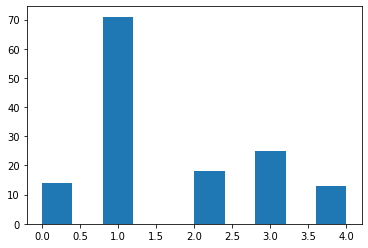

In [ ]:
import matplotlib.pyplot as plt

plt.hist(Y_test)

In [ ]:
# #Confusion Matrix
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt

# from sklearn.metrics import confusion_matrix
# array = confusion_matrix(Y_test, predictions_SVM)
# # df_cm = pd.DataFrame(array, index = ['0','1','2','3','4','5','6','7','8','9'],
# #                   columns =  ['0','1','2','3','4','5','6','7','8','9'])
# df_cm = pd.DataFrame(array, index = ['0','8','9','5','7','1','2'],
#                   columns = ['0','8','9','5','7','1','2'])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm, annot=True)




In [ ]:
models = [
    svm.SVC(C=1.0, kernel='linear', degree=10, gamma='auto'),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [ ]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
y_preds=[]
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, Train_Y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy*100))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 62.522124
LogisticRegression        57.368837
MultinomialNB             55.772756
RandomForestClassifier    55.772756
SVC                       61.281606
Name: accuracy, dtype: float64

In [ ]:
print(cv_df)

                model_name  fold_idx   accuracy
0                      SVC         0  61.946903
1                      SVC         1  62.831858
2                      SVC         2  57.522124
3                      SVC         3  61.607143
4                      SVC         4  62.500000
5   RandomForestClassifier         0  55.752212
6   RandomForestClassifier         1  55.752212
7   RandomForestClassifier         2  55.752212
8   RandomForestClassifier         3  56.250000
9   RandomForestClassifier         4  55.357143
10               LinearSVC         0  65.486726
11               LinearSVC         1  61.061947
12               LinearSVC         2  61.061947
13               LinearSVC         3  61.607143
14               LinearSVC         4  63.392857
15           MultinomialNB         0  55.752212
16           MultinomialNB         1  55.752212
17           MultinomialNB         2  55.752212
18           MultinomialNB         3  56.250000
19           MultinomialNB         4  55

In [ ]:
#Implementing KNN 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

scores={}
scores_list=[]
k_range = range(1,10)
for k in k_range:
  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, Y_train)
  y_pred= knn.predict(X_test)
  temp=metrics.accuracy_score(y_pred,Y_test)
  scores[k]=temp
  scores_list.append(temp)



Text(0, 0.5, 'Testing Accuracy')

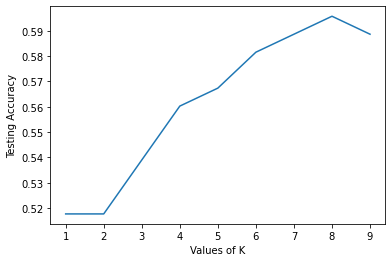

In [ ]:
#Visualize accuracy vs K
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, scores_list)
plt.xlabel("Values of K")
plt.ylabel("Testing Accuracy")

In [ ]:
print(scores_list)

[0.5177304964539007, 0.5177304964539007, 0.5390070921985816, 0.5602836879432624, 0.5673758865248227, 0.5815602836879432, 0.5886524822695035, 0.5957446808510638, 0.5886524822695035]
